# EDA of NSRDB solar radiation data

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import sys
import re
import math

#import statsmodels.api as sm
#import statsmodels.formula.api as smf
#import statsmodels.tsa.api as smt

# Display and Plotting
import matplotlib
import matplotlib.pylab as plt
#import seaborn as sns

# 1. Data set from weather stations

## Exam the meta data 
* https://www1.ncdc.noaa.gov/pub/data/nsrdb-solar/solar-only/documentation/NSRDB_StationsMeta.csv

In [2]:
stations = pd.read_csv("NSRDB_StationsMeta.csv")
stations.head()

,USAF,CLASS,SOLAR,STATION,ST,NSRDB_LAT (dd),NSRDB_LON(dd),NSRDB_ELEV (m),TIME ZONE,ISH_LAT (dd),ISH_LON(dd),ISH_ELEV (m),20070316
0,690140,3,0,EL TORO MCAS,CA,33.667,-117.733,116,-8,33.667,-117.733,116,NaN
1,690150,2,0,TWENTYNINE PALMS,CA,34.300,-116.167,626,-8,34.300,-116.167,626,NaN
2,690160,3,0,TUSTIN MCAF,CA,33.700,-117.833,18,-8,33.700,-117.833,18,NaN
3,690190,2,0,ABILENE DYESS AFB,TX,32.433,-99.850,545,-6,32.433,-99.850,545,NaN
4,690230,2,0,WHIDBEY ISLAND NAS,WA,48.350,-122.667,10,-8,48.350,-122.667,10,NaN


In [3]:
stations_CA = stations[stations['ST'] == 'CA' ]
stations_CA.columns

Index(['USAF', 'CLASS', 'SOLAR', 'STATION', 'ST', 'NSRDB_LAT (dd)',
       'NSRDB_LON(dd)', 'NSRDB_ELEV (m)', 'TIME ZONE', 'ISH_LAT (dd)',
       'ISH_LON(dd)', 'ISH_ELEV (m)', '20070316'],
      dtype='object')

In [4]:
#stations_CA = stations_CA.rename({'NSRDB_LAT (dd)':'lat', 'NSRDB_LON(dd)':'long'}, axis=1)
#stations_CA.drop(['ISH_LAT (dd)', 'ISH_LON(dd)', '20070316'], axis = 1, inplace=True)

In [4]:
stations_CA = stations_CA.reset_index()
stations_CA.head()

,index,USAF,CLASS,SOLAR,STATION,ST,NSRDB_LAT (dd),NSRDB_LON(dd),NSRDB_ELEV (m),TIME ZONE,ISH_LAT (dd),ISH_LON(dd),ISH_ELEV (m),20070316
0,0,690140,3,0,EL TORO MCAS,CA,33.667,-117.733,116,-8,33.667,-117.733,116,NaN
1,1,690150,2,0,TWENTYNINE PALMS,CA,34.300,-116.167,626,-8,34.300,-116.167,626,NaN
2,2,690160,3,0,TUSTIN MCAF,CA,33.700,-117.833,18,-8,33.700,-117.833,18,NaN
3,363,722810,3,0,NAF,CA,32.817,-115.683,-13,-8,32.817,-115.683,-13,NaN
4,364,722860,2,0,MARCH AFB,CA,33.900,-117.250,462,-8,33.900,-117.250,462,NaN


### Generate curl commands for all California stations data

In [5]:
file_list = list(stations_CA['USAF'])

In [7]:
get_files = ['curl https://www1.ncdc.noaa.gov/pub/data/nsrdb-solar/solar-only/' + str(i) + '.tar.gz' + \
             ' -o ' + str(i) + '.tar.gz -s' \
             for i in file_list]
get_files[:5]

['curl https://www1.ncdc.noaa.gov/pub/data/nsrdb-solar/solar-only/690140.tar.gz -o 690140.tar.gz -s',
 'curl https://www1.ncdc.noaa.gov/pub/data/nsrdb-solar/solar-only/690150.tar.gz -o 690150.tar.gz -s',
 'curl https://www1.ncdc.noaa.gov/pub/data/nsrdb-solar/solar-only/690160.tar.gz -o 690160.tar.gz -s',
 'curl https://www1.ncdc.noaa.gov/pub/data/nsrdb-solar/solar-only/722810.tar.gz -o 722810.tar.gz -s',
 'curl https://www1.ncdc.noaa.gov/pub/data/nsrdb-solar/solar-only/722860.tar.gz -o 722860.tar.gz -s']

### Download tar files Example

### To download All stations

In [8]:
import os

for i in get_files:
    os.system(i)

In [11]:
import os
import tarfile
temp = [tarfile.open(name= str(i) + '.tar.gz', mode = 'r').extractall() for i in file_list if os.path.isfile(str(i) + '.tar.gz')]
present_files = [i for i in file_list if os.path.isfile(str(i) + '.tar.gz')]

In [6]:
import os
present_files = [i for i in file_list if os.path.isfile(str(i) + '.tar.gz')]

In [7]:
#Create DataFrame
nsrdb_df = pd.DataFrame()
list_ = []
for i in present_files:
    #list_ = []
    for filename in os.listdir('./nsrdb_solar/' + str(i)):
        df = pd.read_csv('./nsrdb_solar/' + str(i)+ '/'+ str(filename),index_col=None, header=0)
        df['Station_ID'] = i
        list_.append(df)
    #print 'NEXT_' + str(i)
nsrdb_df = pd.concat(list_)


In [8]:
nsrdb_df['Month'] = pd.DatetimeIndex(pd.to_datetime(nsrdb_df['YYYY-MM-DD'])).month

nsrdb_month = nsrdb_df.groupby(['YYYY-MM-DD', 'Month','Station_ID'], as_index = False)[['Precip Wat (cm)', 'AOD (unitless)']].sum()

nsrdb_avg = nsrdb_month.groupby(['Month', 'Station_ID'], as_index = False)[['Precip Wat (cm)', 'AOD (unitless)']].mean()

nsrdb_clust = pd.pivot_table(nsrdb_avg, values=['Precip Wat (cm)', 'AOD (unitless)'], index=['Station_ID'],columns=['Month'])
nsrdb_clust['Station_ID'] = nsrdb_clust.index

lat_long = stations[['USAF', 'NSRDB_LAT (dd)','NSRDB_LON(dd)', 'STATION']]
lat_long.rename(columns={'USAF':'Station_ID'}, inplace=True)

nsrdb_clust_st = pd.merge(nsrdb_clust, lat_long, on = 'Station_ID')
nsrdb_clust_st = nsrdb_clust_st.set_index('Station_ID')
nsrdb_clust = nsrdb_clust_st.drop([('Station_ID', ''), 'STATION'], axis = 1)

//anaconda/lib/python3.5/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
//anaconda/lib/python3.5/site-packages/pandas/tools/merge.py:205: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [9]:
nsrdb_clust[0:5]

,"(Precip Wat (cm), 1)","(Precip Wat (cm), 2)","(Precip Wat (cm), 3)","(Precip Wat (cm), 4)","(Precip Wat (cm), 5)","(Precip Wat (cm), 6)","(Precip Wat (cm), 7)","(Precip Wat (cm), 8)","(Precip Wat (cm), 9)","(Precip Wat (cm), 10)",...,"(AOD (unitless), 5)","(AOD (unitless), 6)","(AOD (unitless), 7)","(AOD (unitless), 8)","(AOD (unitless), 9)","(AOD (unitless), 10)","(AOD (unitless), 11)","(AOD (unitless), 12)",NSRDB_LAT (dd),NSRDB_LON(dd)
Station_ID,,,,,,,,,,,,,,,,,,,,,
690140,32.072903,32.634198,32.219140,32.865778,41.426237,44.234889,57.338280,61.179570,52.204444,39.619570,...,4.767548,5.200578,5.061946,4.660340,4.245191,3.639744,3.111533,3.084258,33.667,-117.733
690150,27.027097,27.358962,27.226667,28.956000,36.308602,39.804889,55.917634,62.240430,49.287556,35.322151,...,2.450520,2.029689,1.937523,2.044413,1.658616,1.651026,1.472680,1.373314,34.300,-116.167
690160,32.286667,32.860142,32.393763,32.919556,41.489892,44.219333,57.345591,61.066452,52.229111,39.696129,...,5.039785,5.338311,5.099404,4.897755,4.465973,3.718723,3.426107,3.163708,33.700,-117.833
722810,30.708387,31.145991,30.636774,32.492000,40.069892,45.827111,67.386452,77.299140,60.923333,41.353333,...,2.997849,2.859009,2.871746,2.937172,2.557240,2.163389,1.691427,1.658862,32.817,-115.683
722860,29.861935,30.382311,30.250968,31.322444,39.523656,42.373778,56.019355,60.038065,50.198667,37.455699,...,3.688396,3.642560,3.619327,3.511432,3.151002,2.701482,2.387933,2.375572,33.900,-117.250


## Clustering Model

In [10]:
from sklearn.cluster import KMeans
clust_matrix = nsrdb_clust.as_matrix()

np.random.seed(0)  #  To ensure repeatability of results
shuffle = np.random.permutation(np.arange(clust_matrix .shape[0]))
X = clust_matrix[shuffle]


#Station IDs
Y = nsrdb_clust.index
Y = Y[shuffle]

#Station Names
Z = np.array(nsrdb_clust_st['STATION'])
Z = Z[shuffle]

Names = nsrdb_clust.columns

## Histogram of Features

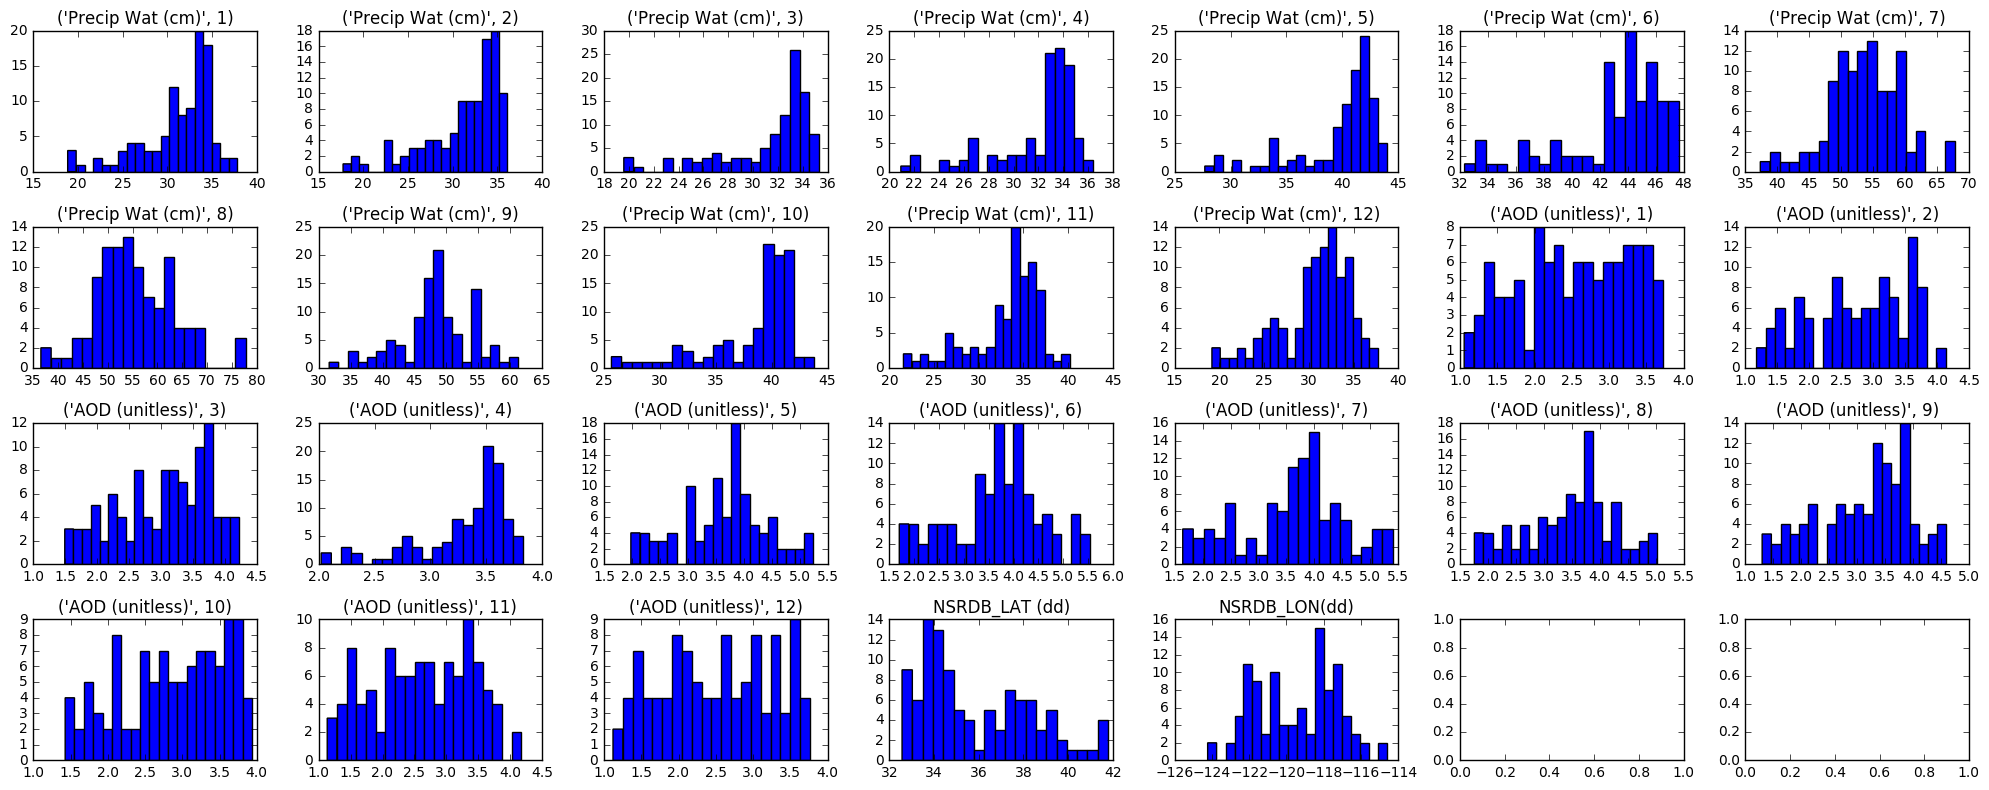

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=7, sharex=False, sharey=False, figsize = (20, 8))

counter =0
for i in range(4):
    for j in range(7):
        
        if counter == 26: break
        
        ax = axes[i,j]
        ax.hist(X[:,counter], bins = 20)
        ax.set_title(Names[counter])
        counter += 1
        fig.tight_layout()
        
plt.show()

In [12]:
#Single Center
km = KMeans (n_clusters=1, init='k-means++')
clstrs = km.fit (X)
print (clstrs.cluster_centers_.shape)
print (clstrs.cluster_centers_)

(1, 26)
[[  31.12844035   31.21735849   31.25465438   31.89368254   39.75086738
    43.0573545    53.63824885   55.54497081   48.45742857   38.41940399
    33.14917672   30.6767107     2.53009694    2.75133068    3.02801868
     3.30344823    3.62915521    3.66782618    3.60584164    3.46282347
     3.14632669    2.85983273    2.61317752    2.51232795   35.8928
  -119.43552381]]


In [19]:
#Five Centers
km = KMeans (n_clusters=5, init='k-means++')
clstrs5 = km.fit (X)
print (clstrs5.cluster_centers_.shape)
print (clstrs5.cluster_centers_)

(5, 26)
[[  33.           32.76327568   33.22977778   33.85869136   41.44635125
    44.9926963    52.18812425   52.0539546    47.36345679   40.10485066
    35.72011852   33.58117563    2.93228875    3.13490755    3.30181271
     3.48205709    3.74201309    3.80849501    3.76318872    3.60874791
     3.40799373    3.15026657    3.02616933    2.91425663   37.50095556
  -121.34588889]
 [  21.78174432   21.12214361   22.29048984   23.73851852   30.6762724
    35.01503704   42.22654719   42.05001195   36.60790123   28.98843489
    24.56246914   22.41218638    1.38934863    1.51261032    1.74146117
     2.32373975    2.16992473    2.04443259    2.01149534    1.98721099
     1.69594025    1.64374409    1.42282691    1.40044444   38.98333333
  -120.00544444]
 [  26.70146237   26.86273585   27.04536201   28.05100741   35.56993548
    38.62321481   51.68362724   54.8403871    45.03312593   33.97718996
    28.60364444   25.97202867    1.71723384    1.88227248    2.23326982
     2.91754474    2.84

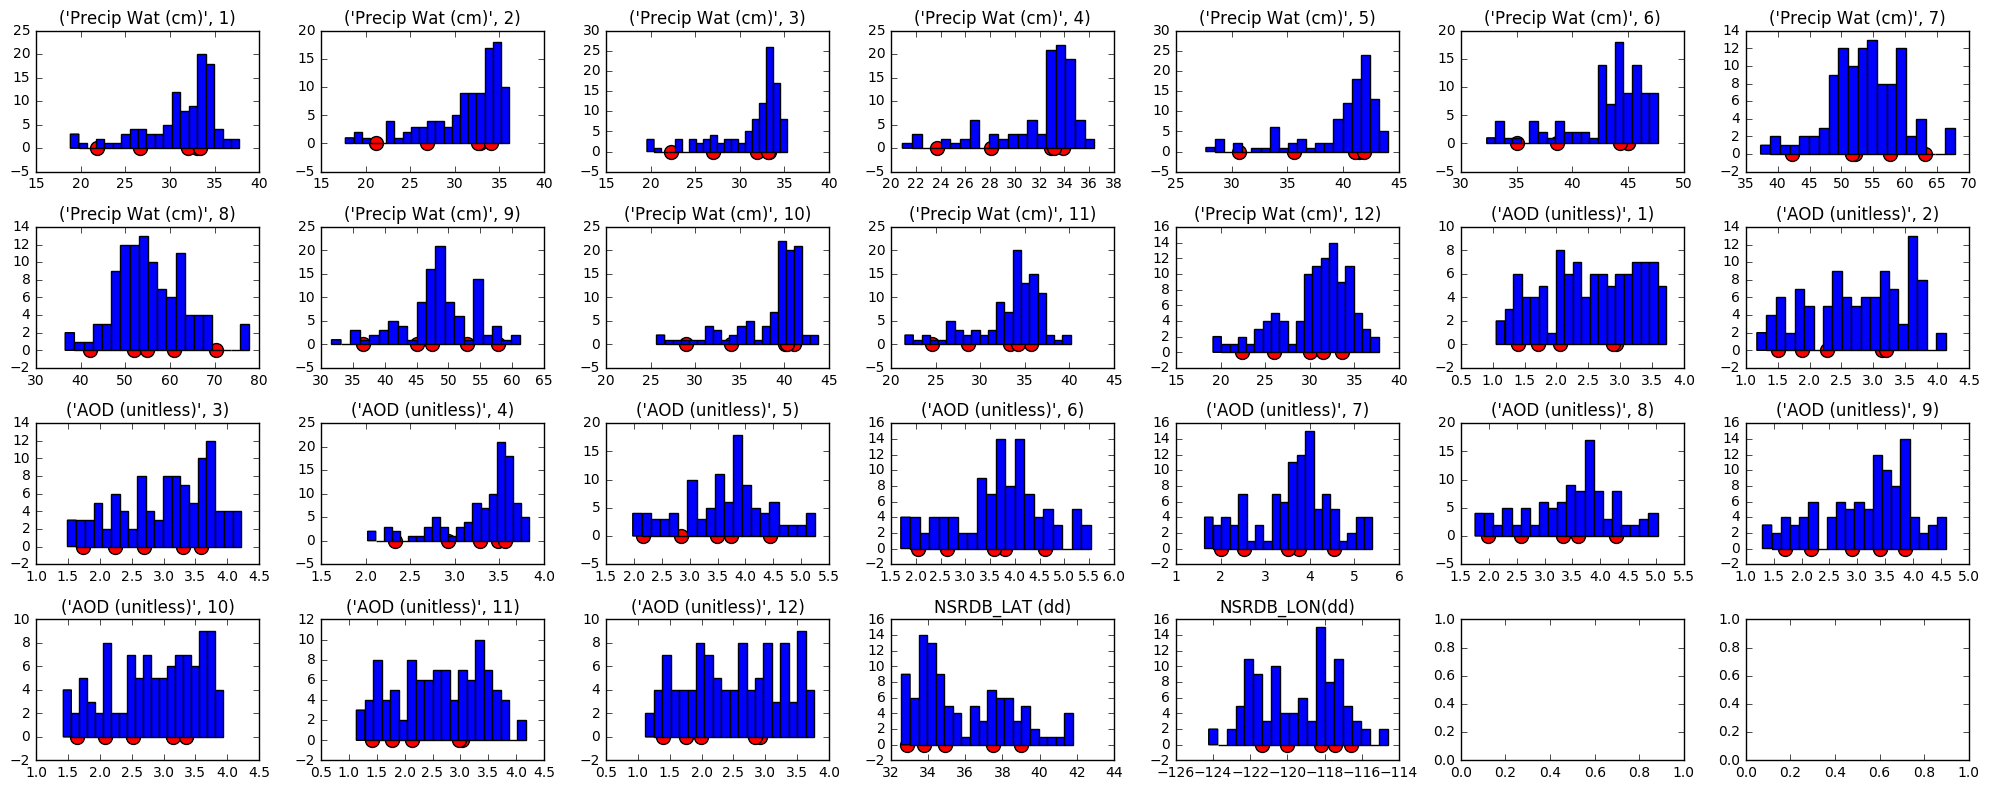

In [20]:
fig, axes = plt.subplots(nrows=4, ncols=7, sharex=False, sharey=False, figsize = (20, 8))

counter =0
for i in range(4):
    for j in range(7):
        
        if counter == 26: break
        
        ax = axes[i,j]
        ax.hist(X[:,counter], bins = 20)
        ax.set_title(Names[counter])
        ax.scatter (x = clstrs5.cluster_centers_[:,counter], y = np.zeros(5), c = 'red', s = 100)
        counter += 1
        fig.tight_layout()
        
plt.show()

### Density Plot

In [21]:
from scipy.stats import gaussian_kde
def DrawDensityPlot(myVector, Name, ax, covar_factor = 0.1):
    data = myVector
    density = gaussian_kde(data)
    minData = min(data)
    maxData = max (data)
    sizeOfData = len(data)
    xs = np.linspace(minData,maxData,sizeOfData)
    density.covariance_factor = lambda : covar_factor
    density._compute_covariance()
    ax.plot(xs,density(xs))
    ax.set_title(Name)
    return ax

---------------------------------
Number of Clusters: 2


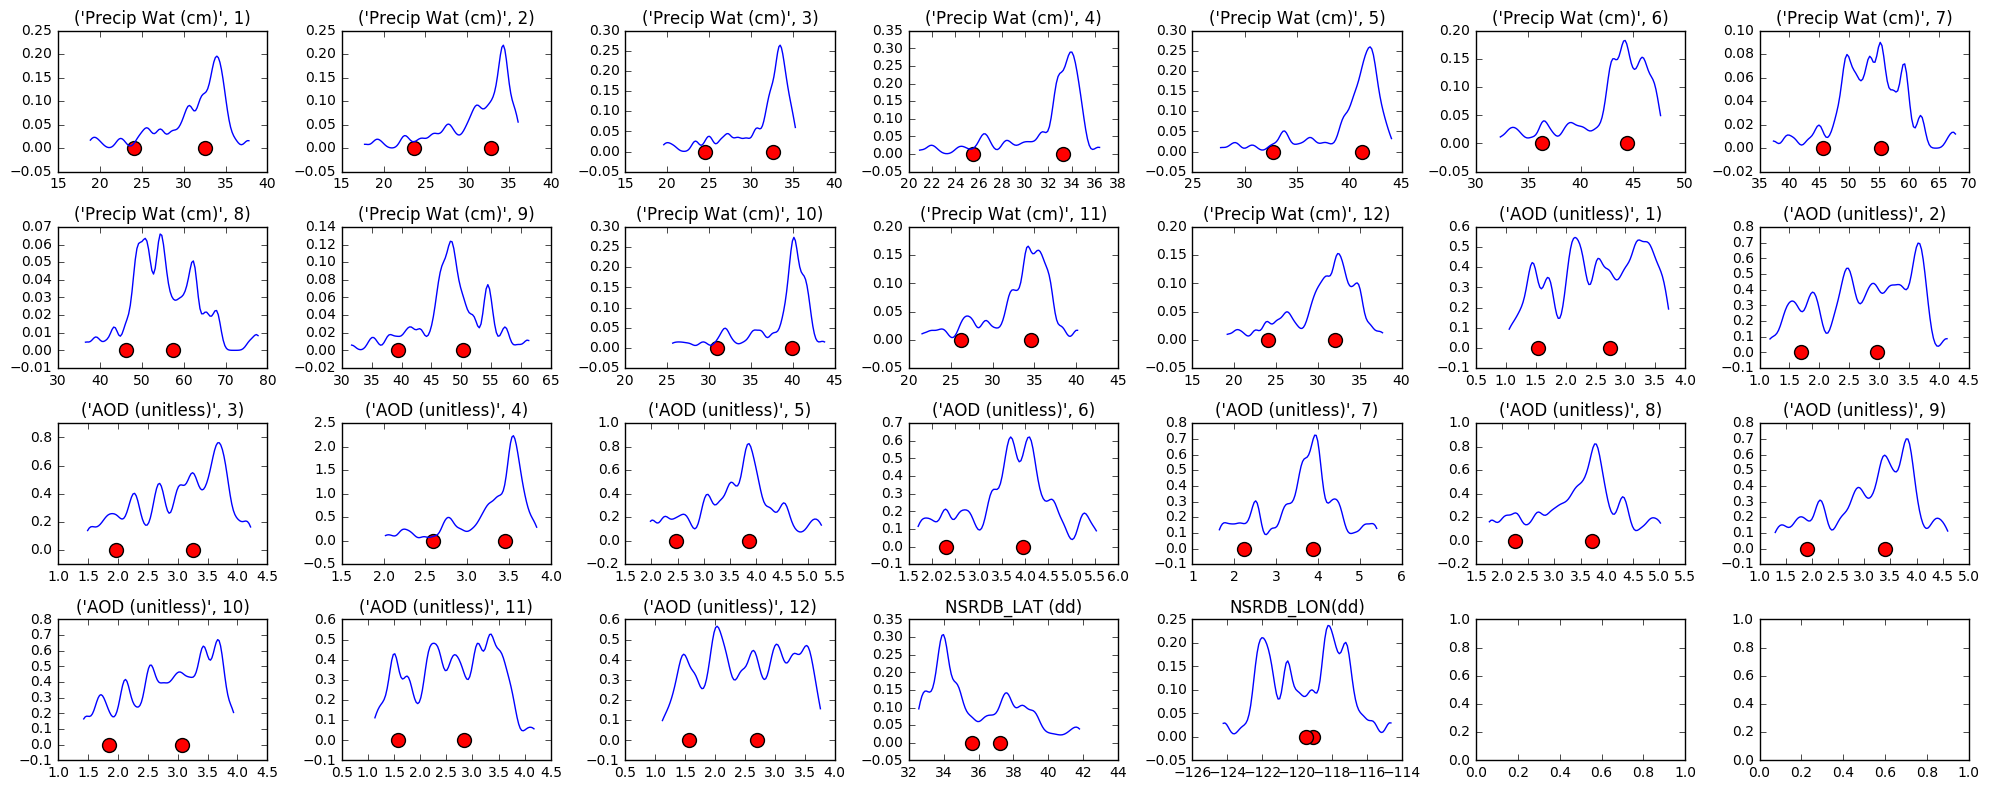

[[  24.01009558   23.68046384   24.48182796   25.49053086   32.70873357
    36.32154321   45.52685783   46.22414576   39.39280247   30.90691756
    26.20045679   24.01249701    1.53389176    1.6845055     1.96499056
     2.58515309    2.46498375    2.30581272    2.2285098     2.24511004
     1.89965037    1.8487141     1.57452062    1.56147814   37.20461111
  -119.11388889]
 [  32.60120133   32.77671601   32.65592881   33.21847254   41.20786059
    44.45097063   55.31646768   57.47341738   50.33286845   39.97371153
    34.58684291   32.05551353    2.73620835    2.97205313    3.24795553
     3.45206102    3.87001827    3.94962207    3.89080685    3.71476418
     3.40425972    3.06902969    2.82807206    2.70905549   35.6213908
  -119.50206897]]
---------------------------------
Number of Clusters: 3


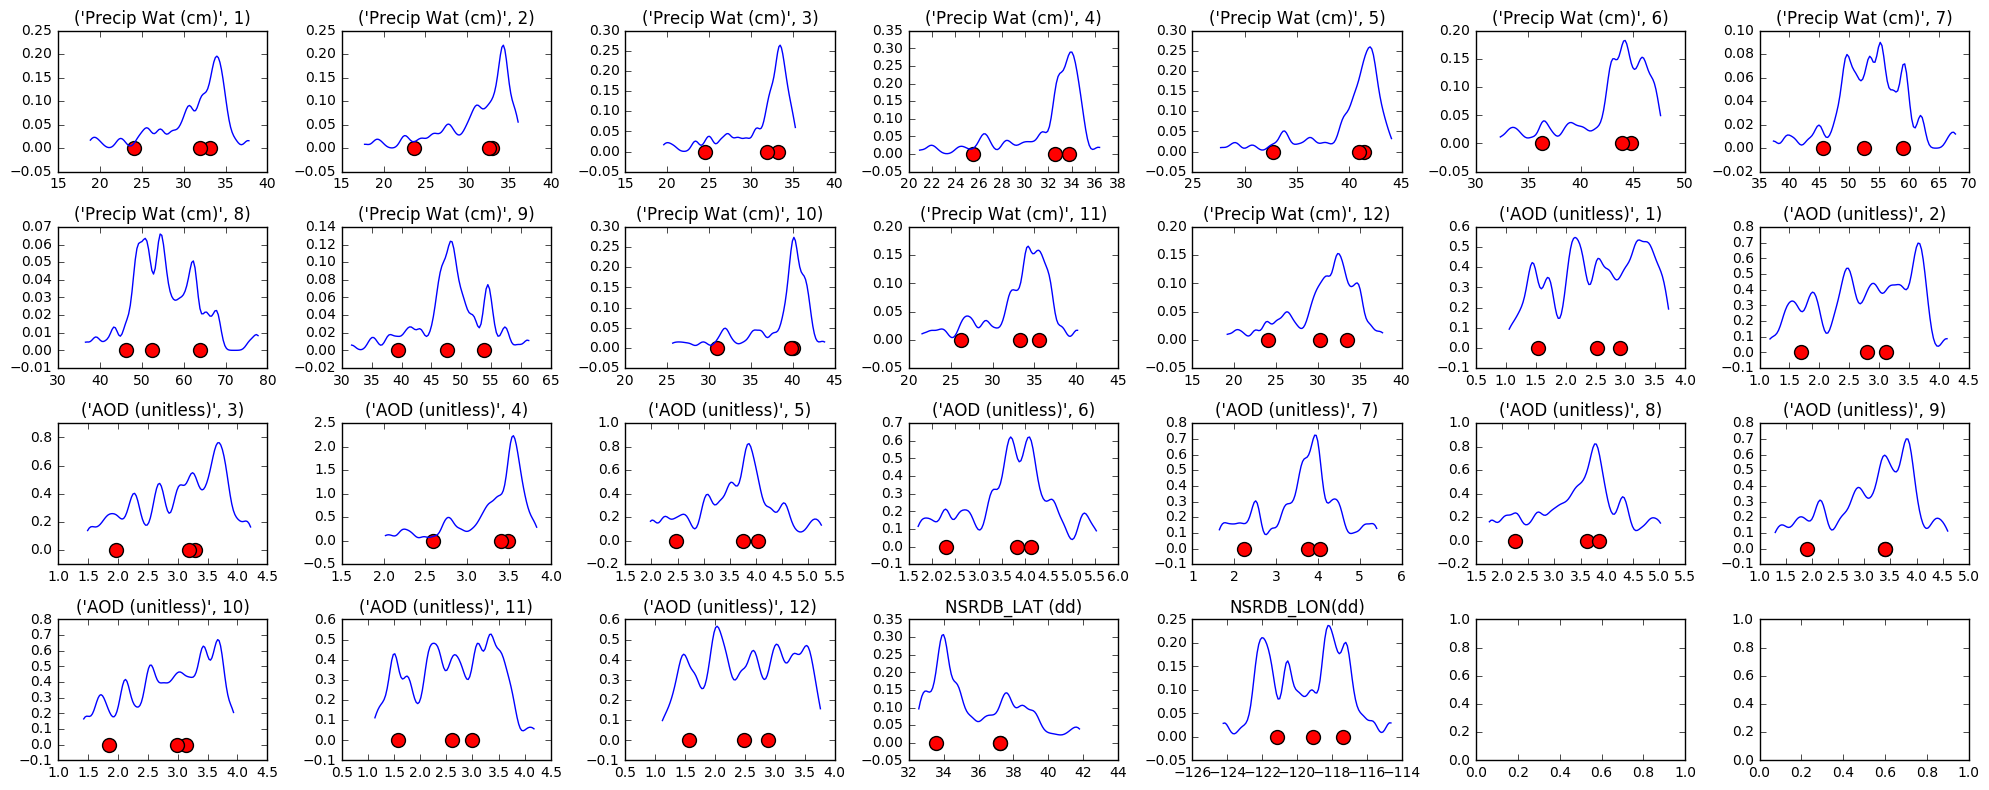

[[  33.08424402   32.92544763   33.23482115   33.74067574   41.41524248
    44.80907029   52.42801843   52.46545095   47.64746939   40.07992978
    35.59884807   33.47034452    2.90438464    3.11266923    3.28821742
     3.49176032    3.74469028    3.81965025    3.77331802    3.61563428
     3.4066824     3.13406899    2.99637719    2.88148334   37.2107551
  -121.17173469]
 [  24.01009558   23.68046384   24.48182796   25.49053086   32.70873357
    36.32154321   45.52685783   46.22414576   39.39280247   30.90691756
    26.20045679   24.01249701    1.53389176    1.6845055     1.96499056
     2.58515309    2.46498375    2.30581272    2.2285098     2.24511004
     1.89965037    1.8487141     1.57452062    1.56147814   37.20461111
  -119.11388889]
 [  31.9783305    32.58493049   31.90946237   32.54510526   40.94044709
    43.98921053   59.04104697   63.93105829   53.79561988   39.8367459
    33.28188889   30.2311262     2.51934946    2.79073237    3.19603888
     3.40086982    4.03162541   

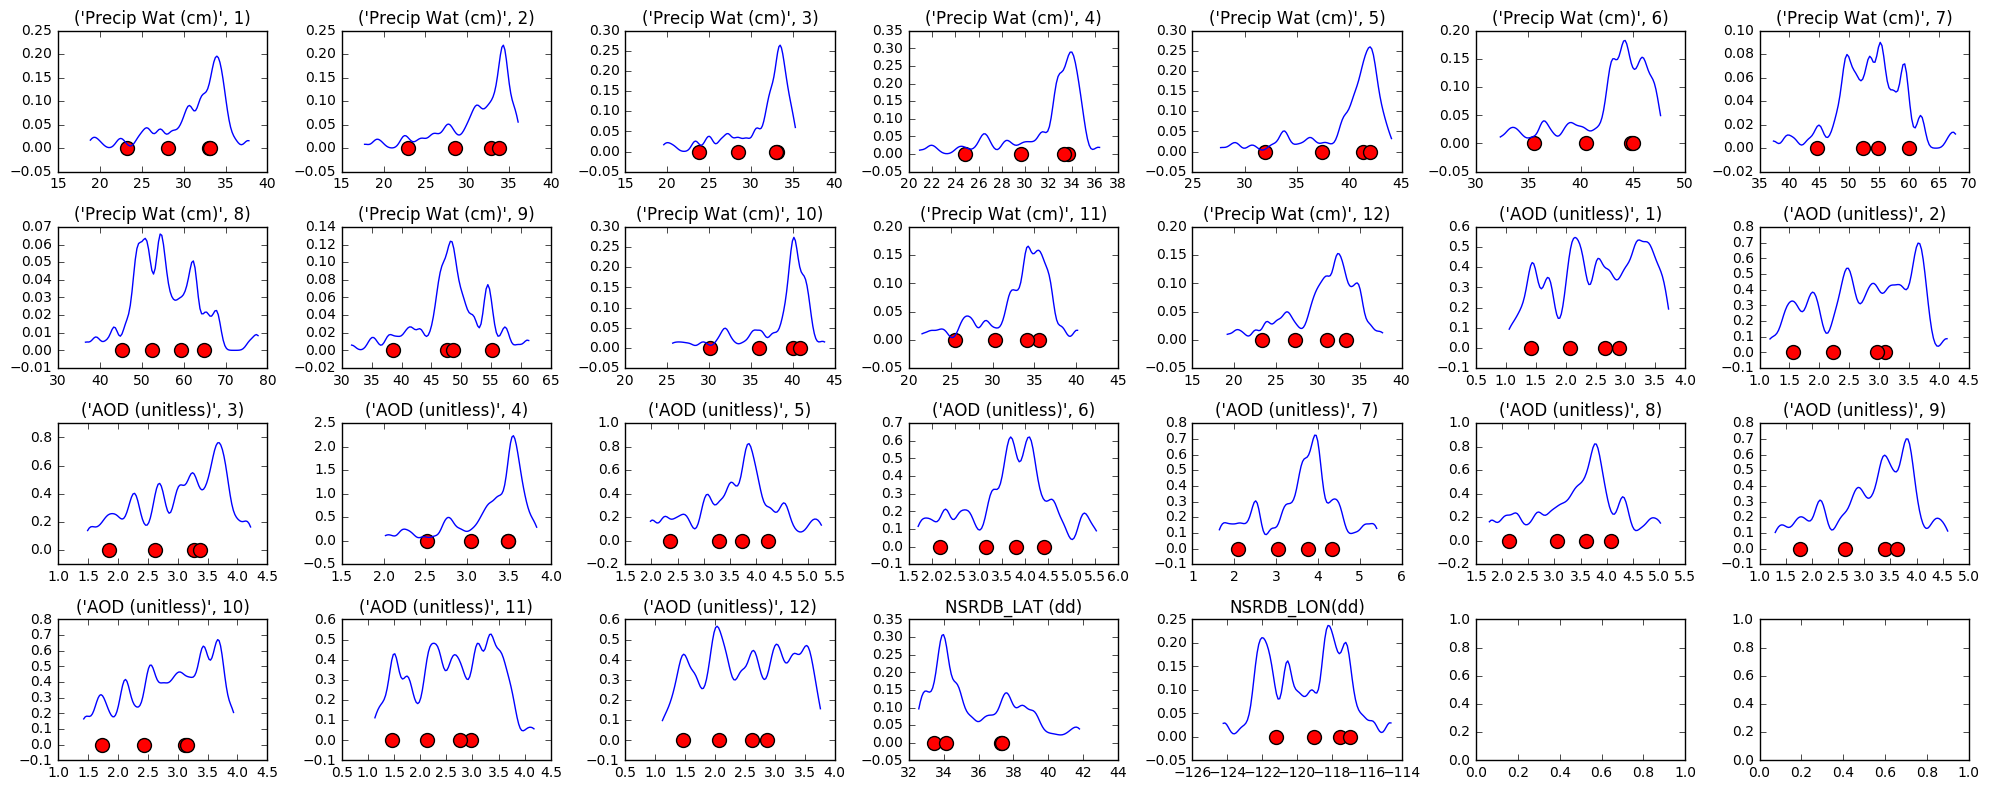

[[  32.99147957   32.80420283   33.13404731   33.66641333   41.33870538
    44.76772444   52.35947097   52.34525161   47.53119556   39.98328602
    35.51308      33.38969892    2.88869858    3.09878486    3.27159923
     3.48745164    3.72902413    3.80793173    3.76091613    3.60153204
     3.39127933    3.11825703    2.97974991    2.86365987   37.27688
  -121.19464   ]
 [  23.27042294   22.92712264   23.78950538   24.82385185   31.93405018
    35.57037037   44.64121864   45.30104659   38.5134963    30.16610753
    25.48285926   23.32068817    1.41594394    1.56508035    1.85516989
     2.51826859    2.36297806    2.16605289    2.08828287    2.12697921
     1.76826681    1.73965935    1.45820815    1.4601081    37.3544
  -119.0522    ]
 [  33.10429366   33.76889232   32.94685206   33.34502682   41.93811643
    44.96133333   60.06195773   64.93739711   55.11243678   40.93279941
    34.13818391   31.12387838    2.66423723    2.96269502    3.37119852
     3.49243134    4.23752814    4.39

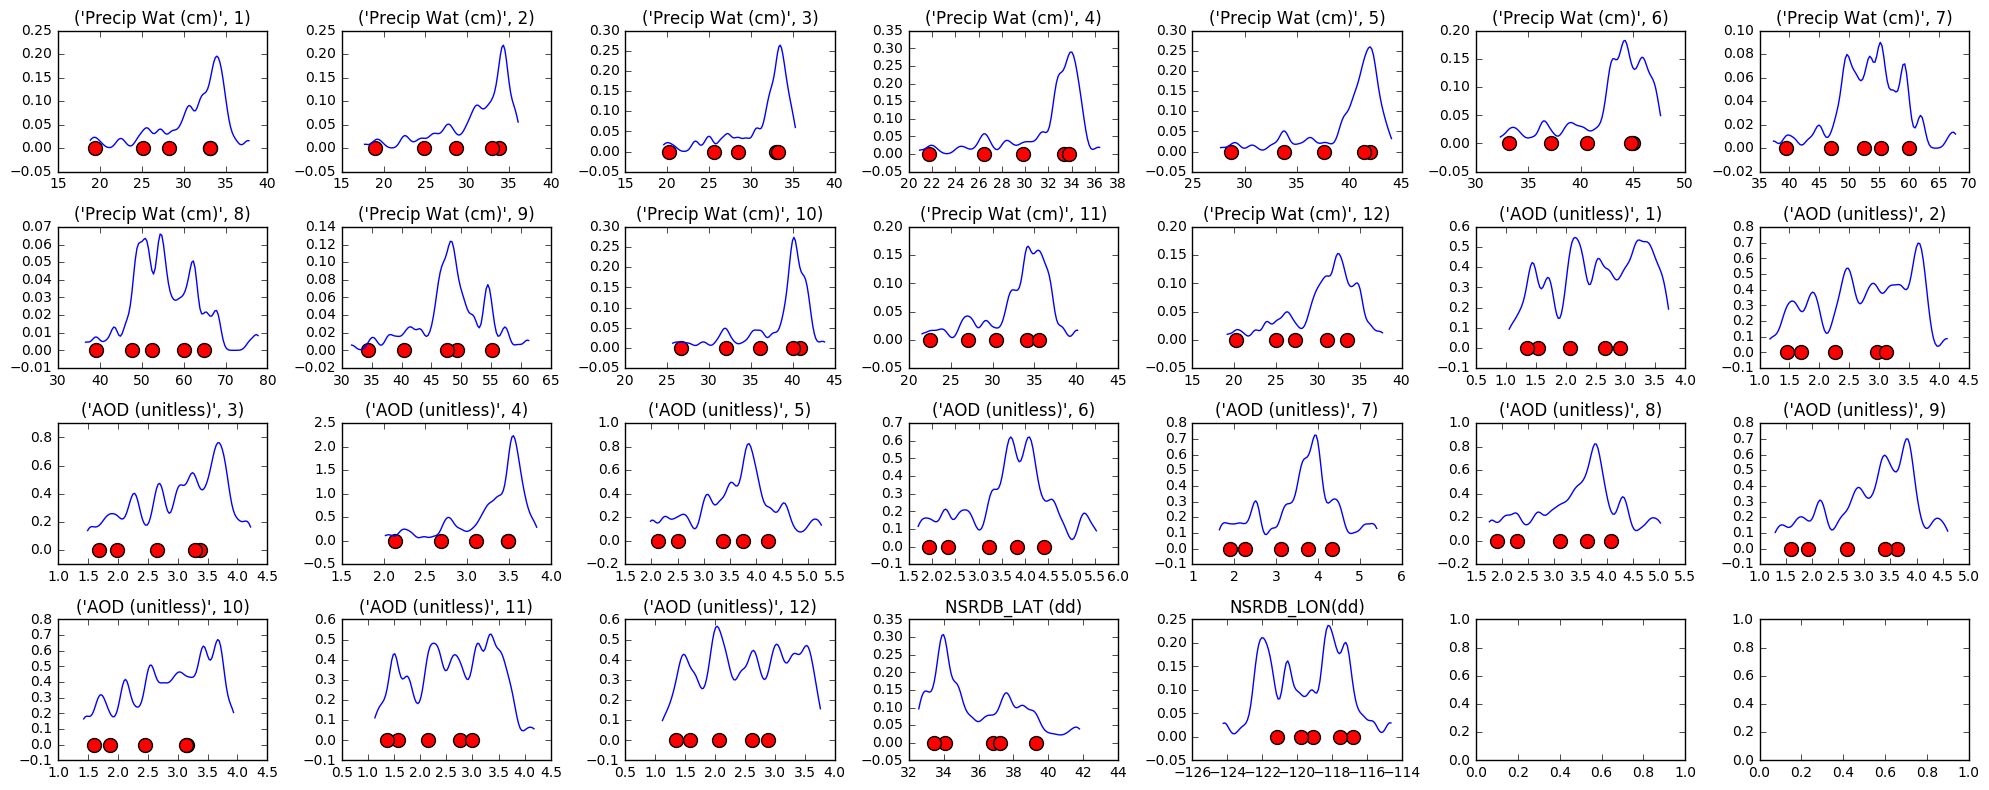

[[  28.23808602   28.64290094   28.43587097   29.78577778   37.53329032
    40.60748889   55.29888172   60.16666667   49.22186667   36.07350538
    30.37771111   27.23625806    2.06987828    2.25353066    2.64578903
     3.10863667    3.36264882    3.21814356    3.1126        3.10098624
     2.667062      2.44957849    2.15090578    2.07516817   34.045
  -116.7634    ]
 [  33.10429366   33.76889232   32.94685206   33.34502682   41.93811643
    44.96133333   60.06195773   64.93739711   55.11243678   40.93279941
    34.13818391   31.12387838    2.66423723    2.96269502    3.37119852
     3.49243134    4.23752814    4.39684199    4.3320941     4.0733191
     3.63262851    3.1551472     2.75951816    2.61934698   33.42703448
  -117.54703448]
 [  25.17707196   24.850127     25.58499586   26.4417094    33.71075269
    37.15430769   46.98681555   47.73023987   40.42984615   31.97510339
    27.09723077   25.02246485    1.53484218    1.69744176    1.99066203
     2.68171128    2.50410538    2.3

In [22]:
##  Use the ShowDensityPlot function:

def ApplyKMeansShowDensity (N, X = X, show_hist_and_centers = True, kde_covar_factor = 0.1):
    
    print ("---------------------------------")
    print ("Number of Clusters: %d" % (N))
    km = KMeans (n_clusters=N, init='k-means++')
    clstrs = km.fit (X)
    
    fig, axes = plt.subplots(nrows=4, ncols=7, sharex=False, sharey=False, figsize = (20, 8))
    counter =0
    for i in range(4):
        for j in range(7):

            if counter == 26: break

            ax = axes[i,j]
            ax = DrawDensityPlot(myVector = X[:,counter], Name = Names[counter], ax = ax, covar_factor = kde_covar_factor)
            ax.scatter (x = clstrs.cluster_centers_[:,counter], y = np.zeros(N), c = 'red', s = 100)            
            counter += 1
            fig.tight_layout()
    
    
    
    #fig, axes = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=False, figsize = (16, 4))
    #for ii in np.arange (0, X.shape[1]):
        #ax = axes[ii]
        #ax = DrawDensityPlot(myVector = X[:,ii], Name = Names[ii], ax = ax, covar_factor = kde_covar_factor)
        #ax.scatter (x = clstrs.cluster_centers_[:,ii], y = np.zeros(N), c = 'red', s = 100)

    plt.show()

    print (clstrs.cluster_centers_)

    return clstrs

#for nn in [1,2,3,4,5,6,7,8,9,10]:
for nn in [2,3,4,5]:  ##  Single cluster is an exercise in futility, and we already know that >=5 clusters is already too many
    clstrs = ApplyKMeansShowDensity(nn, kde_covar_factor =0.1125)
    

### BIC for Cluster Optimization

In [23]:
from scipy.spatial import distance
def compute_bic(kmeans,X):
    '''
    Computes the BIC metric for a given clusters

    Parameters:
    -----------------------------------------
    kmeans:  List of clustering objects from scikit-learn
    X     :  multidimensional np array of data points

    Returns:
    -----------------------------------------
    BIC value
    '''
    # assign centers and labels
    centers = [kmeans.cluster_centers_]
    labels  = kmeans.labels_
    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape

    #compute variance for all clusters beforehand
    cl_var = [(1.0 / (n[i] - m)) * sum(distance.cdist(X[np.where(labels == i)], [centers[0][i]], 'euclidean')**2)  for i in range(m)]

    const_term = 0.5 * m * np.log10(N)

    BIC = np.sum([n[i] * np.log10(n[i]) -
           n[i] * np.log10(N) -
         ((n[i] * d) / 2) * np.log10(2*np.pi) -
          (n[i] / 2) * np.log10(cl_var[i]) -
         ((n[i] - m) / 2) for i in range(m)]) - const_term

    return BIC

for ff in np.arange (X.shape[1]):

    myX = X[:,ff].reshape (len (X[:,ff]), 1)
    print (Names[ff])
    # print myX.shape
    
    for nn in [1,2,3,4,5,6,7,8,9]:
        km = KMeans (n_clusters=nn, init='k-means++')
        clstrs = km.fit (myX)
        bic = compute_bic(clstrs, myX)
        print ("Feature: %s. Number of clusters = %d.  BIC = %.3f" % (Names[ff], nn, bic))



('Precip Wat (cm)', 1)
Feature: ('Precip Wat (cm)', 1). Number of clusters = 1.  BIC = -158.977
Feature: ('Precip Wat (cm)', 1). Number of clusters = 2.  BIC = -153.060
Feature: ('Precip Wat (cm)', 1). Number of clusters = 3.  BIC = -154.907
Feature: ('Precip Wat (cm)', 1). Number of clusters = 4.  BIC = -153.997
Feature: ('Precip Wat (cm)', 1). Number of clusters = 5.  BIC = -156.101
Feature: ('Precip Wat (cm)', 1). Number of clusters = 6.  BIC = -153.054
Feature: ('Precip Wat (cm)', 1). Number of clusters = 7.  BIC = nan
Feature: ('Precip Wat (cm)', 1). Number of clusters = 8.  BIC = nan
Feature: ('Precip Wat (cm)', 1). Number of clusters = 9.  BIC = nan
('Precip Wat (cm)', 2)
Feature: ('Precip Wat (cm)', 2). Number of clusters = 1.  BIC = -160.797
Feature: ('Precip Wat (cm)', 2). Number of clusters = 2.  BIC = -152.580
Feature: ('Precip Wat (cm)', 2). Number of clusters = 3.  BIC = -152.257
Feature: ('Precip Wat (cm)', 2). Number of clusters = 4.  BIC = -148.736
Feature: ('Precip Wa

## Initial Model 

In [24]:
km = KMeans (n_clusters=10, init='k-means++')
clstrs_final = km.fit (X)

In [25]:
clstrs_final.labels_

array([9, 6, 0, 6, 8, 6, 3, 6, 2, 6, 6, 2, 0, 0, 3, 7, 0, 0, 0, 3, 7, 2, 4,
       2, 5, 2, 7, 2, 8, 8, 6, 7, 6, 2, 2, 9, 9, 6, 5, 2, 2, 4, 3, 2, 1, 7,
       3, 2, 9, 7, 7, 3, 2, 2, 0, 0, 9, 2, 0, 0, 0, 0, 0, 0, 0, 2, 5, 1, 1,
       0, 6, 2, 2, 9, 0, 0, 4, 3, 6, 9, 1, 2, 2, 9, 3, 5, 6, 2, 7, 6, 6, 0,
       9, 1, 6, 2, 0, 9, 2, 3, 0, 2, 6, 6, 6], dtype=int32)

In [26]:
clust_regions = pd.DataFrame(np.stack((Z,clstrs_final.labels_), axis = 1))
clust_regions.columns = ('Station', 'Cluster')

In [27]:
clust_regions.loc[clust_regions['Cluster'] == 3]

,Station,Cluster
6,CHINO AIRPORT,3
14,BEAUMONT 1 E,3
19,PALM SPRINGS INTL,3
42,TWENTYNINE PALMS,3
46,MARCH AFB,3
51,ONTARIO,3
77,PALM SPRINGS THERMAL AP,3
84,NEEDLES AIRPORT,3
99,RIVERSIDE MUNI,3


In general the regions are geographically in similar areas.  Since the lat/long are higher values they are having a larger impact for our distance calc.  Next we should experiment normalzing the data so it's unitless. 

## Model with Normalized Data 

In [13]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
scaler_geo = preprocessing.MinMaxScaler(feature_range=(0,5))

In [14]:
#Data Normalization

lat_lon_norm = nsrdb_clust.iloc[:,-2:]
#lat_lon_norm = lat_lon_norm.apply(scaler.fit_transform)
lat_lon_norm = lat_lon_norm.apply(scaler_geo.fit_transform)

precip_norm = nsrdb_clust.iloc[:,:-2]
precip_norm = precip_norm.apply(scaler.fit_transform)

clust_norm = pd.concat([precip_norm, lat_lon_norm], axis=1)

/Users/ericyang/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/ericyang/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/ericyang/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if yo

In [15]:
norm_matrix = clust_norm.as_matrix()

np.random.seed(0)  #  To ensure repeatability of results
shuffle = np.random.permutation(np.arange(norm_matrix .shape[0]))
X = norm_matrix[shuffle]


#Station IDs
Y = nsrdb_clust.index
Y = Y[shuffle]

#Station Names
Z = np.array(nsrdb_clust_st['STATION'])
Z = Z[shuffle]

In [43]:
km = KMeans (n_clusters=10, init='k-means++')
clstrs_final = km.fit (X)

In [17]:
clust_regions = pd.DataFrame(np.stack((Z,clstrs_final.labels_), axis = 1))
clust_regions.columns = ('Station', 'Cluster')

In [33]:
clust_regions.loc[clust_regions['Cluster'] == 5]

,Station,Cluster
8,PASO ROBLES MUNICIPAL ARPT,5
34,VANDENBERG AFB,5
47,SAN LUIS CO RGNL,5
53,VANDENBERG RANGE,5
57,SANTA MARIA PUBLIC ARPT,5
58,SANTA BARBARA MUNICIPAL AP,5
71,LOMPOC (AWOS),5


## Optimal Cluster Analysis 

In [47]:
avg_dist = []
for i in np.arange(1,16):
    km_opt = KMeans (n_clusters=i, init='k-means++')
    km_opt_final = km_opt.fit (X)
    avg_dist.append(km_opt_final.inertia_)

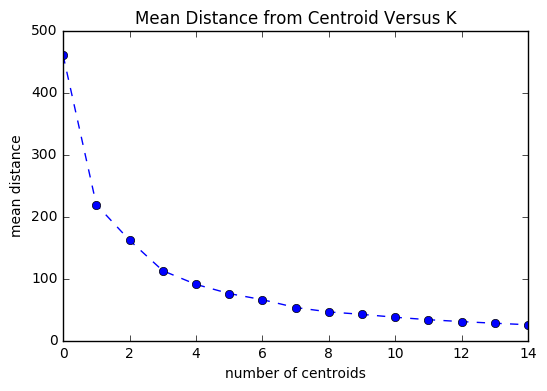

In [48]:
plt.plot(avg_dist, linestyle='--', marker='o')
plt.ylabel('mean distance')
plt.xlabel('number of centroids')
plt.title('Mean Distance from Centroid Versus K')
plt.show()

Looks like at 8/9 centroids we gains start to flatten out

# Check Lat/Long for 8 Cluster Model

In [126]:
centers = 20

km = KMeans (n_clusters=centers, init='k-means++')
clstrs_final = km.fit (X)


Lat = np.array(nsrdb_clust_st['NSRDB_LAT (dd)'])[shuffle]
Long = np.array(nsrdb_clust_st['NSRDB_LON(dd)'])[shuffle]

clust_regions = pd.DataFrame(np.stack((Z,clstrs_final.labels_, Lat, Long), axis = 1))
clust_regions.columns = ('Station', 'Cluster', 'Lat', 'Long')

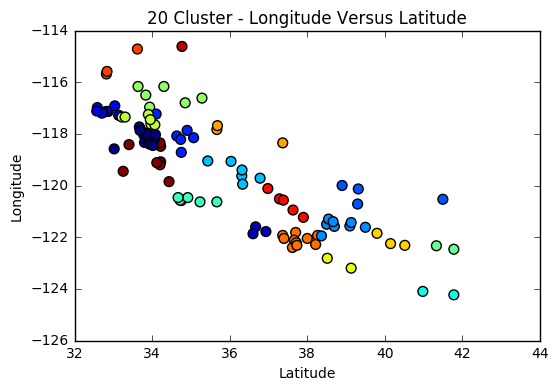

In [128]:
plt.scatter(clust_regions['Lat'], clust_regions['Long'], c=clust_regions['Cluster'], s = 50)
#plt.legend
plt.ylabel('Longitude')
plt.xlabel('Latitude')
plt.title(str(centers) + ' Cluster - Longitude Versus Latitude')
plt.show()

### Find distance to Centroid 

In [95]:
from scipy.spatial import distance

dist_to_centroid = []
for i in range(len(X)):
    dist_to_centroid.append(distance.euclidean(X[i],km.cluster_centers_[clust_regions['Cluster'][i]]))

In [97]:
clust_regions['Centroid_Dist'] = dist_to_centroid
clust_regions.to_csv('test.csv')